### Advanced Models 
This notebook contains several attempts at creating Simple Neural Networks, Recurrent Neural Networks, and Long Short Term Memory (LSTM) networks for my Forecasting Energy Demand Capstone. 

In [3]:
#Holy Trinity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Graphing
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import seaborn as sns

#Neural Network
#import tensorflow as tf
#from tensorflow import keras #import only what I need (?), this is alot I think
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

In [4]:
#Read in csv and store as a dataframe and take a look
ercot_df = pd.read_csv('capstone_data/ercot_2008_2019.csv')

#Convert 'hour_end' to datetime
ercot_df['hour_end'] = pd.to_datetime(ercot_df['hour_end'])

#Drop if exists
#ercot_df.drop(['month', 'is_summer', 'day_of_week', 'is_weekday', 'hour'], axis = 1, inplace = True);

#Insert 'month' identifier column
ercot_df.insert(1, 'month', ercot_df['hour_end'].dt.month)

#Insert `is_summer` identifier column
ercot_df.insert(2, 'is_summer', ercot_df['month'].apply(lambda x: 1 if x in [6, 7, 8] else 0))

#Insert 'day_of_week' indentifier column
#NOTE: Monday = 0, Sunday = 6
ercot_df.insert(3, 'day_of_week', ercot_df['hour_end'].dt.dayofweek)

#Insert `is_weekday` identifier column, weekend days are 5, 6
ercot_df.insert(4, 'is_weekday', np.where(ercot_df["day_of_week"] == (5 or 6), 0, 1))

#Insert 'hour' indentifier column
ercot_df.insert(5, 'hour', ercot_df['hour_end'].dt.hour)

#Make a df where the date is the index
ercot_time_df = ercot_df.set_index("hour_end")
ercot_time_df.index.name = None
ercot_time_df.head()

,month,is_summer,day_of_week,is_weekday,hour,coast,east,far_west,north,north_c,southern,south_c,west,ercot
2008-01-01 01:00:00,1,0,1,1,1,7582.426275,1137.197278,1289.741591,1120.591245,10782.48780,1894.920943,4857.044340,932.251506,29596.66098
2008-01-01 02:00:00,1,0,1,1,2,7483.387277,1129.312429,1320.549720,1130.163920,10873.00119,1826.089194,4867.512567,939.958255,29569.97455
2008-01-01 03:00:00,1,0,1,1,3,7381.744778,1155.484647,1328.442079,1129.355056,10952.63748,1832.883827,4849.639885,951.322118,29581.50987
2008-01-01 04:00:00,1,0,1,1,4,7452.871868,1209.918355,1344.322369,1148.919804,11104.17876,1819.248340,4858.047321,967.450488,29904.95730
2008-01-01 05:00:00,1,0,1,1,5,7530.354017,1265.055389,1355.020035,1171.267839,11369.93504,1834.777369,4962.345559,996.055206,30484.81045


In [27]:
#Let's make an ercot-column-only monthly df:
#ercot_time_df_monthly_ercot = ercot_time_df['ercot'].resample('MS').sum()

In [28]:
#Set up train and test sets
#train, test = np.split(ercot_time_df_monthly_ercot, [int(.80 *len(ercot_time_df_monthly_ercot))])

---

### LSTM1 Model
[Reference1](https://towardsdatascience.com/arima-vs-lstm-forecasting-electricity-consumption-3215b086da77)\
[Reference2](https://blog.paperspace.com/time-series-forecasting-regression-and-lstm/)\
[Keras Sequential Model](https://keras.io/guides/sequential_model/)\
[LTSM Layer](https://keras.io/api/layers/recurrent_layers/lstm/)\
Here is the first attempt at an LSTM Model. 

In [59]:
mini_df = pd.DataFrame(ercot_time_df['ercot'], columns = ['ercot'])
mini_df.head()

,ercot
2008-01-01 01:00:00,29596.66098
2008-01-01 02:00:00,29569.97455
2008-01-01 03:00:00,29581.50987
2008-01-01 04:00:00,29904.95730
2008-01-01 05:00:00,30484.81045


In [60]:
###############################################################################
#Uncomment this out if you want to scale BEFORE splitting for train and test sets
###############################################################################

#Apply scaler to normalize data
from sklearn.preprocessing import MinMaxScaler

#Instantiate
scaler = MinMaxScaler()

#Fit and transform
mini_df['ercot'] = scaler.fit_transform(mini_df.values.reshape(-1,1)) 

In [61]:
#Check to see that it's been scaled
mini_df.head()

,ercot
2008-01-01 01:00:00,0.180475
2008-01-01 02:00:00,0.179990
2008-01-01 03:00:00,0.180200
2008-01-01 04:00:00,0.186081
2008-01-01 05:00:00,0.196625


Now that the data is scaled, a lookback period needs to be implemented, i.e. how many prior periods we wish for the LSTM model to take into account when forecasting at time t. First we'll bring in a function that takes in data and sequence length and then returns a train/test split.

In [62]:
#Make def that takes in data and sequence length and then returns a train/test split
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i - seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[84152:]    
    y_test = y_train[84152:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:84152]           
    y_train = y_train[:84152]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return [X_train, y_train, X_test, y_test]

Let's create train and test sets using the new function:

In [63]:
%%time
#Create train, test data
seq_len = 12 #In the example the sequence length is 20...why? How to chose sequence length? 
X_train, y_train, X_test, y_test = load_data(mini_df, seq_len)

print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ', y_test.shape)

X_train.shape =  (84152, 12)
y_train.shape =  (84152,)
X_test.shape =  (21027, 12)
y_test.shape =  (21027,)


In [64]:
#Check to see that data is still scaled
y_test

array([0.55875061, 0.50094953, 0.4357931 , ..., 0.37229394, 0.35747522,
       0.34014168])

In [65]:
y_train

array([0.22321234, 0.20414762, 0.189571  , ..., 0.6321354 , 0.59947327,
       0.58425959])

In [66]:
X_train

array([[0.18047506, 0.1799898 , 0.18019956, ..., 0.25511071, 0.25178576,
        0.24166914],
       [0.1799898 , 0.18019956, 0.18608107, ..., 0.25178576, 0.24166914,
        0.22321234],
       [0.18019956, 0.18608107, 0.19662501, ..., 0.24166914, 0.22321234,
        0.20414762],
       ...,
       [0.42880397, 0.43295588, 0.45497793, ..., 0.63769419, 0.65236508,
        0.65159572],
       [0.43295588, 0.45497793, 0.48811594, ..., 0.65236508, 0.65159572,
        0.6321354 ],
       [0.45497793, 0.48811594, 0.52164981, ..., 0.65159572, 0.6321354 ,
        0.59947327]])

In [67]:
X_test

array([[0.48811594, 0.52164981, 0.55299998, ..., 0.6321354 , 0.59947327,
        0.58425959],
       [0.52164981, 0.55299998, 0.57502222, ..., 0.59947327, 0.58425959,
        0.55875061],
       [0.55299998, 0.57502222, 0.59337569, ..., 0.58425959, 0.55875061,
        0.50094953],
       ...,
       [0.4945101 , 0.46350942, 0.42848321, ..., 0.37358481, 0.40261436,
        0.38928163],
       [0.46350942, 0.42848321, 0.39498625, ..., 0.40261436, 0.38928163,
        0.37229394],
       [0.42848321, 0.39498625, 0.36480494, ..., 0.38928163, 0.37229394,
        0.35747522]])

It all appears to be scaled correctly. 

In [5]:
#Reshape data to input into RNN models
X_train = np.reshape(X_train, (84152, seq_len, 1)) #Instead of 84152 could it be int(.8*(len(mini_df)))?
X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ', y_test.shape)

NameError: name 'X_train' is not defined

In [71]:
#Run LSTM Model 

%%time
window_size = 12

# Create new LSTM model
LSTM_model = Sequential()

#Declare hidden layers
LSTM_model.add(Dense(1))
LSTM_model.add(LSTM(4, input_shape = (1, window_size)))

#Declare output layer
LSTM_model.add(Dense(1))

#Compile model
LSTM_model.compile(optimizer = 'adam', loss = 'MSE')

#Train model
LSTM_model.fit(X_train, y_train, epochs = 5, batch_size = 12) #Epochs was originally 100 in example

#Check r2 score for predicted values
LSTM_predictions = LSTM_model.predict(X_test)

LSTM_score = r2_score(y_test, LSTM_predictions)
print("R^2 Score of LSTM model = ", LSTM_score)

Epoch 1/5
7013/7013 [==============================] - 15s 2ms/step - loss: 0.0028
Epoch 2/5
7013/7013 [==============================] - 15s 2ms/step - loss: 1.9855e-04
Epoch 3/5
7013/7013 [==============================] - 15s 2ms/step - loss: 1.8805e-04
Epoch 4/5
7013/7013 [==============================] - 15s 2ms/step - loss: 1.8479e-04
Epoch 5/5
7013/7013 [==============================] - 15s 2ms/step - loss: 1.7958e-04
R^2 Score of LSTM model =  0.9952080939404987
Wall time: 1min 16s


And R^2 of 99.5% is pretty great. Although I did not include any dropout layers so this is likely way overfit. 

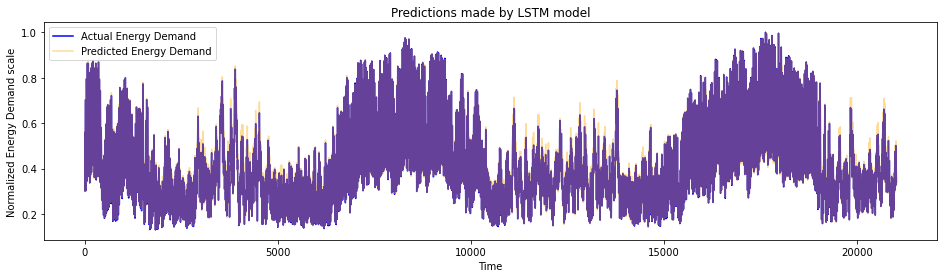

In [77]:
#Compare actual values vs predicted on graph
#def plot_predictions(test, predicted, title):
plt.figure(figsize = (16,4))
plt.plot(y_test, color = 'blue', label = 'Actual Energy Demand')
plt.plot(LSTM_predictions, alpha = 0.4, color = 'orange', label = 'Predicted Energy Demand')
plt.title("Predictions made by LSTM model")
plt.xlabel('Time')
plt.ylabel('Normalized Energy Demand scale')
plt.legend()
plt.show()
    
#plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")
#Compare actual values vs predicted on graph

#plot_predictions(y_test, LSTM_predictions, "Predictions made by LSTM model")

These predictions look really good. The model is fitting really well to the training data, though with more time I need to look into controlling the overfitting more. 

---
### RNN attempt following Kaggle set
[Kaggle Example](https://www.kaggle.com/msripooja/hourly-energy-consumption-time-series-rnn-lstm)\
[Time Series in RNN Reference](https://www.javatpoint.com/tensorflow-time-series-in-rnn)

In [10]:
ercot_time_df.head()

,month,is_summer,day_of_week,is_weekday,hour,coast,east,far_west,north,north_c,southern,south_c,west,ercot
2008-01-01 01:00:00,1,0,1,1,1,7582.426275,1137.197278,1289.741591,1120.591245,10782.48780,1894.920943,4857.044340,932.251506,29596.66098
2008-01-01 02:00:00,1,0,1,1,2,7483.387277,1129.312429,1320.549720,1130.163920,10873.00119,1826.089194,4867.512567,939.958255,29569.97455
2008-01-01 03:00:00,1,0,1,1,3,7381.744778,1155.484647,1328.442079,1129.355056,10952.63748,1832.883827,4849.639885,951.322118,29581.50987
2008-01-01 04:00:00,1,0,1,1,4,7452.871868,1209.918355,1344.322369,1148.919804,11104.17876,1819.248340,4858.047321,967.450488,29904.95730
2008-01-01 05:00:00,1,0,1,1,5,7530.354017,1265.055389,1355.020035,1171.267839,11369.93504,1834.777369,4962.345559,996.055206,30484.81045


In [82]:
mini_df = pd.DataFrame(ercot_time_df['ercot'], columns = ['ercot'])
mini_df

,ercot
2008-01-01 01:00:00,29596.66098
2008-01-01 02:00:00,29569.97455
2008-01-01 03:00:00,29581.50987
2008-01-01 04:00:00,29904.95730
2008-01-01 05:00:00,30484.81045
...,...
2019-12-31 19:00:00,41812.98000
2019-12-31 20:00:00,41079.76000
2019-12-31 21:00:00,40145.54000
2019-12-31 22:00:00,39330.60000


In [83]:
#Create train and test sets
#mini_train, mini_test = np.split(mini_df, [int(.80 *len(mini_df))])
#mini_train

In [84]:
#Apply scaler
from sklearn.preprocessing import MinMaxScaler

#Instantiate
scaler = MinMaxScaler()

#Fit scaler and transform
mini_df['ercot'] = scaler.fit_transform(mini_df.values.reshape(-1,1)) #Transform all data for now
#mini_train['ercot'] = scaler.fit_transform(mini_train.values.reshape(-1, 1))
#mini_test['ercot'] = scaler.fit_transform(mini_test.values.reshape(-1, 1)) 

In [85]:
#Scaling whole dataset isn't good, need to do to only the train set
mini_df

,ercot
2008-01-01 01:00:00,0.180475
2008-01-01 02:00:00,0.179990
2008-01-01 03:00:00,0.180200
2008-01-01 04:00:00,0.186081
2008-01-01 05:00:00,0.196625
...,...
2019-12-31 19:00:00,0.402614
2019-12-31 20:00:00,0.389282
2019-12-31 21:00:00,0.372294
2019-12-31 22:00:00,0.357475


In [80]:
#Check to see if it's scaled
#mini_train

In [108]:
# #Plot scaled training set
# mini_train.plot(figsize = (16,4), legend = True)
# mini_test.plot(figsize = (16,4), legend = True)
# plt.title('ERCOT Hourly Energy Demand - AFTER NORMALIZATION')
# plt.show()

In [362]:
# #Turn train and test into series
# mini_train = mini_train.squeeze()
# mini_test = mini_test.squeeze()

# #Turn the whole scaled df to series
# mini_df = mini_df.squeeze()

In [107]:
# #Eyes on train and test set splits
# fig = go.Figure()

# fig.add_trace(go.Scatter(x = mini_train.index, y = mini_train, mode = 'lines', name = "Train"))
# fig.add_trace(go.Scatter(x = mini_test.index, y = mini_test, mode = 'lines', name = "Test"))

# #Activate slider
# fig.update_xaxes(rangeslider_visible = True)
# fig.show()

Step 3. Prepare data for training the RNN models

In [87]:
#Now split the entire scaled dataset
#mini_train, mini_test = np.split(mini_df, [int(.80 *len(mini_df))])

In [88]:
#mini_train

In [89]:
#mini_test

In [90]:
#What are X and y in RNN for time series? 
#X = time?
#Y = energy?

In [91]:
# #Convert to np array
# X_train = np.array(mini_train.index)
# y_train = np.array(y_train)

# X_test = np.array(X_test)
# y_test = np.array(y_test)

# #4 reshape data to input into RNN models
# X_train = np.reshape(X_train, (110000, seq_len, 1))
# X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))

In [92]:
#Convert to dataframe
#mini_df = pd.DataFrame(mini_df)

In [93]:
#What is 80% of the data? For the train set
print(.80*105191)

84152.8


In [94]:
#Check
mini_df[:84152]

,ercot
2008-01-01 01:00:00,0.180475
2008-01-01 02:00:00,0.179990
2008-01-01 03:00:00,0.180200
2008-01-01 04:00:00,0.186081
2008-01-01 05:00:00,0.196625
...,...
2017-08-07 05:00:00,0.374951
2017-08-07 06:00:00,0.395095
2017-08-07 07:00:00,0.428804
2017-08-07 08:00:00,0.432956


In [95]:
#Prepare data for training the RNN models
#Make def that takes in data and sequence length and then returns a train/test split
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i - seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[84152:]    
    y_test = y_train[84152:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:84152]           
    y_train = y_train[:84152]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (84152, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [96]:
#Create train, test data
seq_len = 12 #In the example the sequence length is 20...why? How to chose sequence length? 

X_train, y_train, X_test, y_test = load_data(mini_df, seq_len)

print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ', y_test.shape)

X_train.shape =  (84152, 12, 1)
y_train.shape =  (84152,)
X_test.shape =  (21027, 12, 1)
y_test.shape =  (21027,)


Step 4. Build a simple RNN model \
[Reference from TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN)

In [97]:
#Build Simple RNN model 
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.models import Sequential

#Build Model
rnn_model = Sequential()

#Add hidden layer
rnn_model.add(SimpleRNN(40, activation = "tanh", 
                        return_sequences = True, 
                        input_shape = (X_train.shape[1],1)))
#Adjust for overfitting
rnn_model.add(Dropout(0.15))

#Add hidden layer
rnn_model.add(SimpleRNN(40, activation = "tanh",
                        return_sequences = True))

#Adjust for overfitting
rnn_model.add(Dropout(0.15))

#Add hidden layer
rnn_model.add(SimpleRNN(40, activation = "tanh", 
                        return_sequences = False))

#Adjust for overfitting
rnn_model.add(Dropout(0.15))

#Add output layer
rnn_model.add(Dense(1))

display(rnn_model.summary())

#Run model
rnn_model.compile(optimizer = "adam", loss = "MSE", metrics = ['accuracy'])
rnn_model.fit(X_train, y_train, epochs = 10, batch_size = 1000)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 12, 40)            1680      
_________________________________________________________________
dropout (Dropout)            (None, 12, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 12, 40)            3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                

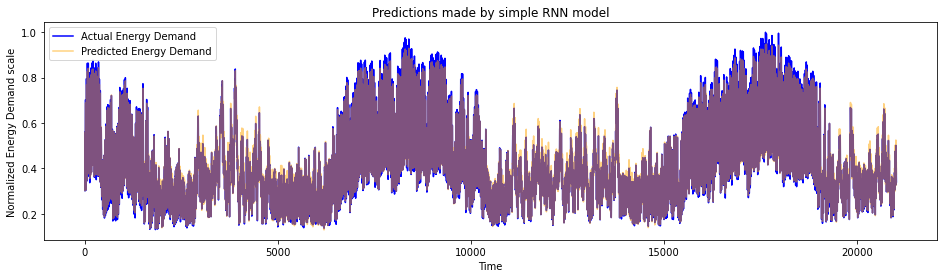

R^2 Score of RNN model =  0.9780389543860171


In [102]:
#Predict
rnn_predictions = rnn_model.predict(X_test)

#Score
rnn_score = r2_score(y_test, rnn_predictions)

#Compare actual values vs predicted on graph
def plot_predictions(test, predicted, title):
    plt.figure(figsize = (16,4))
    plt.plot(test, color = 'blue', label = 'Actual Energy Demand')
    plt.plot(predicted, alpha = 0.5, color = 'orange', label = 'Predicted Energy Demand')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized Energy Demand scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

print("R^2 Score of RNN model = ", rnn_score)

This model is also scoring really well, with an R^2 of 98%. It's fitting the data really nicely even at such a granular level, though more testing, forecasting, and tuning to account for overfitting still need to be taken as next steps.

---
### LSTM2 Model
Here is a second attempt at an LSTM model. 

In [105]:
#Build LSTM Model
#Create new sequential model
lstm_model = Sequential()

#Add 3 hidden layers, with dropout to control overfitting
lstm_model.add(LSTM(40, activation = "tanh", 
                    return_sequences = True, 
                    input_shape = (X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40, activation = "tanh", 
                    return_sequences = True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40, activation = "tanh", 
                    return_sequences = False))
lstm_model.add(Dropout(0.15))

#Declare output layer
lstm_model.add(Dense(1))

display(lstm_model.summary())

#Run model 
lstm_model.compile(optimizer = "adam", loss = "MSE")
lstm_model.fit(X_train, y_train, epochs = 10, batch_size = 1000)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 12, 40)            6720      
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 40)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 12, 40)            12960     
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 40)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_8 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                

None

Epoch 1/10
85/85 [==============================] - 4s 49ms/step - loss: 0.0299
Epoch 2/10
85/85 [==============================] - 4s 50ms/step - loss: 0.0148
Epoch 3/10
85/85 [==============================] - 4s 51ms/step - loss: 0.0080
Epoch 4/10
85/85 [==============================] - 4s 51ms/step - loss: 0.0043
Epoch 5/10
85/85 [==============================] - 4s 51ms/step - loss: 0.0029
Epoch 6/10
85/85 [==============================] - 4s 49ms/step - loss: 0.0023
Epoch 7/10
85/85 [==============================] - 4s 49ms/step - loss: 0.0020
Epoch 8/10
85/85 [==============================] - 4s 50ms/step - loss: 0.0018
Epoch 9/10
85/85 [==============================] - 4s 49ms/step - loss: 0.0016
Epoch 10/10
85/85 [==============================] - 4s 48ms/step - loss: 0.0015


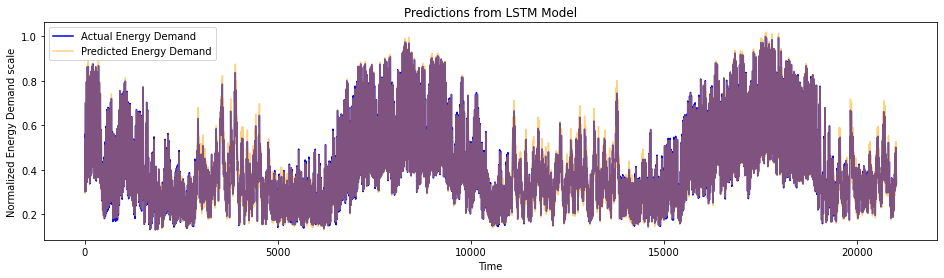

R^2 Score of LSTM model =  0.9845689609817418


In [106]:
#Predict
lstm_predictions = lstm_model.predict(X_test)

#Score
lstm_score = r2_score(y_test, lstm_predictions)

#Compare actual values vs predicted on graph
def plot_predictions(test, predicted, title):
    plt.figure(figsize = (16,4))
    plt.plot(test, color = 'blue', label = 'Actual Energy Demand')
    plt.plot(predicted, alpha = 0.5, color = 'orange', label = 'Predicted Energy Demand')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized Energy Demand scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, lstm_predictions, "Predictions from LSTM Model")

print("R^2 Score of LSTM model = ", lstm_score)

This graph also looks great. R^2 of .98 is nice. Again the same comments as before can be made. 

---
### NN Model

In [109]:
#Set up train and test sets
train, test = np.split(ercot_time_df['ercot'], [int(.80 *len(ercot_time_df))])

#Build Model
#Create a new sequential model
model = keras.Sequential() #Change

#Declare the hidden layers
model.add(layers.Dense(5, activation = "linear"))
model.add(layers.Dense(5, activation = "linear"))
model.add(layers.Dense(5, activation = "linear"))
model.add(layers.Dense(5, activation = "linear"))
model.add(layers.Dense(5, activation = "linear"))

# Declare the output layer
model.add(layers.Dense(1, activation = "linear"))

#Compile Model 
model.compile(optimizer = "adam", loss = "MSE", metrics = [tf.keras.metrics.MeanSquaredError()])

#Train Model 
history = model.fit(train, train, epochs = 50, verbose = 1) 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

2630/2630 [==============================] - 1s 465us/step - loss: 201315.2031 - mean_squared_error: 201315.2031
Epoch 2/50
2630/2630 [==============================] - 1s 454us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3/50
2630/2630 [==============================] - 1s 454us/step - loss: 938.8037 - mean_squared_error: 938.8037
Epoch 4/50
2630/2630 [==============================] - 1s 457us/step - loss: 1722.5883 - mean_squared_error: 1722.5883
Epoch 5/50
2630/2630 [==========

The remainder of this model was not seen to completion and still needs debugging. Next steps could be started here. 

In [115]:
# #Predict
# model_predictions = model.predict(X_test)

# #Score
# model_score = r2_score(y_test, model_predictions)

# #Compare actual values vs predicted on graph
# def plot_predictions(test, predicted, title):
#     plt.figure(figsize = (16,4))
#     plt.plot(test, color = 'blue', label = 'Actual Energy Demand')
#     plt.plot(predicted, alpha = 0.5, color = 'orange', label = 'Predicted Energy Demand')
#     plt.title(title)
#     plt.xlabel('Time')
#     plt.ylabel('Normalized Energy Demand scale')
#     plt.legend()
#     plt.show()
    
# plot_predictions(y_test, model_predictions, "Predictions made by simple Neural Network model")

# print("R^2 Score of NN model = ", model_score)

In [110]:
# #Evaluate
# # Get the accuracy of train set
# train_accuracy = history.history['mean_squared_error'][-1] #Why -1?
# print(f"Train Accuracy: {train_accuracy:.4f}")

# # Evaluate with test set
# result = model.evaluate(X_test, y_test, verbose = 0)
# print(f"Test Accuracy: {result[1]:.4f}")

In [111]:
# # Visualize the training, epoch vs loss
# plt.figure()
# plt.plot(history.history['loss'], marker = '.')
# plt.xlabel('Epoch of training')
# plt.ylabel('loss')
# plt.title('Loss for Model Training')
# plt.show()

In [112]:
# # Visualize the training, epoch vs accuracy
# plt.figure()
# plt.plot(history.history['accuracy'], marker = '.')
# plt.xlabel('Epoch of training')
# plt.ylabel('loss')
# plt.title('Loss for Model Training')
# plt.show()

In [113]:
# #Compare actual values vs predicted on graph
# def plot_predictions(test, predicted, title):
#     plt.figure(figsize = (16,4))
#     plt.plot(test, color = 'blue', label = 'Actual Energy Demand')
#     plt.plot(predicted, alpha = 0.5, color = 'orange', label = 'Predicted Energy Demand')
#     plt.title(title)
#     plt.xlabel('Time')
#     plt.ylabel('Normalized Energy Demand scale')
#     plt.legend()
#     plt.show()
    
# plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

[KNN and SVM Reference](https://www.sciencedirect.com/science/article/pii/S266616592030034X)

---
### KNN Model
[KNN and SVM Reference](https://www.sciencedirect.com/science/article/pii/S266616592030034X)

In [119]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# ############
# #Transform data by scaling - SUPER IMPORTANT for any distance based method
# X = train.values
# y = train.index

# #Instantiate and fit
# scaler = StandardScaler().fit(train) #

# #Transform
# train_scaled = scaler.transform(train) #
# test_scaled = scaler.transform(test) #

# ###########
# #Model
# #Instantiate Model
# KNNmodel = KNeighborsRegressor(n_neighbors=50, weights='uniform')

# #Fit model
# KNNmodel.fit(X_train[:, [0,3]], y_train)

# #Score
# print(f"R^2 score on training set: {KNNmodel.score(X_train[:, [0,3]], y_train):0.3f}")
# print(f"R^2 score on test set: {KNNmodel.score(X_test[:, [0,3]], y_test):0.3f}")

A drawback of KNN is that it can never predict values outside the range it's seen before. Since the training set includes some extreme energy demand fluctuations, we should likely be ok as most future values will be accounted for. 

---
### Notes

In [109]:
#NOTE: This is from reference2 
# function for generating the lagged matrix
def split_sequence(sequence, window_size):
    X = []
    y = []
    # for all indexes
    for i in range(len(sequence)):
        end_idx = i + window_size
        # exit condition
        if end_idx > len(sequence) - 1:
            break
        # get X and Y values
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

## Library
Everything below here is a graveyard of code. 

---
### Trying to use Regression Example from Intro to NN Lesson:

In [1]:
# #Instantiate and fit
# scaler = StandardScaler().fit(train) #

# #Transform
# train_scaled = scaler.transform(train) #
# test_scaled = scaler.transform(test) #

In [ ]:
# # Create a new sequential model
# model = keras.Sequential()

# # Declare the hidden layers
# model.add(layers.Dense(40, activation="relu"))
# model.add(layers.Dense(40, activation="relu"))

# # Declare the output layer
# model.add(layers.Dense(1)) # For regression, we don't specify any activation function.

# # Compile the model
# model.compile(optimizer = 'Adam', loss = keras.losses.MeanSquaredError())
    
# history = model.fit(X_train, y_train, epochs = 50, verbose = 0
                    
# from sklearn.metrics import r2_score
# r2_score(y_test,y_pred)

---
### Trying to use example from RNN Lesson:

In [16]:
# # Evaluate the model using the test data and generate predictions
# train_loss = history.history["loss"][-1]
# result = model.evaluate(X_test, y_test, verbose=0)
# print(f"Train Loss: {train_loss:.4f}")
# print(f"Test Loss: {result:.4f}")
# y_pred = model.predict(X_test)

In [17]:
# RNN = Sequential() #Change, sequential only uses 1 input

# RNN.add(Embedding(number_of_classes, 8))

# RNN.add(LSTM(128, activation ='linear', return_sequences = False))
# RNN.add(BatchNormalization())

# RNN.add(Dense(64, activation ='linear'))
# RNN.add(BatchNormalization())

# RNN.add(Dense(number_of_classes, activation = 'linear'))

In [18]:
# # Compile model
# RNN.compile(loss = 'mean squared error',
#                       optimizer = Adam(lr = 0.001),
#                       metrics = ['accuracy'])

In [19]:
# #Check r2 score for predicted values
# lstm_predictions = lstm_model.predict(X_test)

# lstm_score = r2_score(y_test, lstm_predictions)
# print("R^2 Score of LSTM model = ", lstm_score)

In [20]:
# #Compare actual values vs predicted on graph
# plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

In [109]:
###############################################################################
#Uncomment this out if you want to scale AFTER splitting for train and test sets
###############################################################################

#Prepare data for applying scaler
#Need to reshape y_train and y_test
# y_train = y_train.reshape(84152,1)
# y_test = y_test.reshape(21027,1)

# #Apply scaler to normalize data
# from sklearn.preprocessing import MinMaxScaler

# #Instantiate and fit scaler
# scaler = MinMaxScaler().fit(X_train)

# #Transform train and test data
# X_train = scaler.transform(X_train)
# y_train = scaler.transform(y_train)
# X_test = scaler.transform(X_test)
# y_test = scaler.transform(y_test)

In [30]:
# #Try to do the above plot but in plotly:
# def plot_predictions_plotly(test, predicted, title):
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(test, mode = 'lines', name = "Actual"))
#     fig.add_trace(go.Scatter(predictions, mode = 'lines', name = "Predictions"))
#     fig.update_xaxes(rangeslider_visible = True)
#     fig.show()

# plot_predictions_plotly(y_test, rnn_predictions, "Predictions made by simple RNN model")